# Programming for Data Analytics Project
# Analysis of Wind Speed and Wind Energy in Ireland

*Author: Eoghan Walsh*
***

This project uses Python and various libraries to analyse wind speed and wind energy in Ireland, and aims to identify possible trends in hourly and monthly wind speed data, explore the relationship between energy demand and wind energy generation, and predict future wind speed.
* **Data Visualisation:** Plot wind speed and energy data using ``matplotlib`` and ``seaborn``.
* **Trend Analysis:** Indentify hourly and monthly trends in the data.
* **Prediction:** Use ``scikit-learn``'s decision tree regression to forcast future wind speeds.

## Import Modules

In [308]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from matplotlib.ticker import AutoMinorLocator
import seaborn as sns
import csv
import re
import requests
from io import StringIO
from sklearn import tree
from map import ireland_map

## Import and Clean the Monthly Windspeed Data

In [309]:
# Function to import and clean the monthly weather date.
def import_monthly_data():

    # File containing csv URLs.
    txt_file = "./data/download-file-list-monthly.txt"

    # Regex pattern to find the start of useful data in CSV files.
    regex = r"^year(?!:)"

    # Columns to import to dataframe.
    columns = ["year","month", "wdsp"]

    # Numeric columns.
    numeric_columns = ["wdsp"]

    # List to store the dataframes.
    dataframes = []

    # Regex pattern to find the column header row in CSV files.
    regex_pattern = re.compile(regex, re.IGNORECASE)

    # Read the URLs from the txt file and strip newlines.
    with open(txt_file) as f:
        csv_urls = [line.strip() for line in f if line.strip()]

    # Loop through the URLs.
    for url in csv_urls:
        try:
            # Send GET request to the URL.
            # https://realpython.com/python-requests/#the-get-request
            response = requests.get(url)
            if response.status_code != 200:
                print(f"Failed to retrieve the CSV file. Status code: {response.status_code}")
                continue

            # Treat response content as file-like object.
            # https://www.slingacademy.com/article/python-requests-module-handle-csv-response/
            csv_content = response.text
            csv_file = StringIO(csv_content)

            # Find the station name & row with column headers.
            csv_reader = csv.reader(csv_file)

            station_name = ",".join(next(csv_reader)).split("Station Name: ")[1].lower().replace(" ", "_")

            for row_number, row in enumerate(csv_reader):
                row_string = ",".join(row)
                if regex_pattern.search(row_string):
                    break
            else:
                print(f"Error finding regex pattern: \"{regex_pattern.pattern}\" in {url}")
                continue

            # Reset the file pointer and import the data to DataFrame.
            # https://geekpython.medium.com/moving-and-locating-the-file-pointer-in-python-fa32758f7054
            csv_file.seek(0)
            df = pd.read_csv(csv_file, skiprows=row_number, usecols=columns)

            # Add new date column.
            df['date'] = pd.to_datetime(df['year'].astype(str) + '-' + df['month'].astype(str))
            
            # Set date column as index.
            df = df.set_index('date')

            # Drop year and month columns.
            df = df.drop(columns=['year', 'month'])

            # Convert data to numeric.
            for col in numeric_columns:
                df[col] = pd.to_numeric(df[col], errors="coerce")

            # Replace any blanks with NAs.
            df = df.replace(" ", np.nan)

            # Update column names to include station name.
            df.columns = [f"{station_name}"]

            # Append dataframes to list.
            dataframes.append(df)

            print(f"Imported {url} as {station_name}")

        except Exception as e:
            print(f"An error occurred while processing {url} ({station_name}): {e}")

    return dataframes


# Call the function.
monthly_dataframes = import_monthly_data()

Imported https://cli.fusio.net/cli/climate_data/webdata/mly1875.csv as athenry
Imported https://cli.fusio.net/cli/climate_data/webdata/mly675.csv as ballyhaise
Imported https://cli.fusio.net/cli/climate_data/webdata/mly2375.csv as belmullet
Imported https://cli.fusio.net/cli/climate_data/webdata/mly3723.csv as casement
Imported https://cli.fusio.net/cli/climate_data/webdata/mly2175.csv as claremorris
Imported https://cli.fusio.net/cli/climate_data/webdata/mly3904.csv as cork_airport
Imported https://cli.fusio.net/cli/climate_data/webdata/mly532.csv as dublin_airport
Imported https://cli.fusio.net/cli/climate_data/webdata/mly1375.csv as dunsany
Imported https://cli.fusio.net/cli/climate_data/webdata/mly2075.csv as finner
Imported https://cli.fusio.net/cli/climate_data/webdata/mly1475.csv as gurteen
Imported https://cli.fusio.net/cli/climate_data/webdata/mly1775.csv as johnstown_castle_2
Imported https://cli.fusio.net/cli/climate_data/webdata/mly4935.csv as knock_airport
Imported https:/

In [ ]:
# Combine into one dataframe and normalize based on the date index.
# https://pandas.pydata.org/docs/reference/api/pandas.concat.html#pandas-concat
monthly_df = pd.concat(monthly_dataframes, axis=1, join='inner')

# Let's take a look.
monthly_df.info()

In [341]:
# Import and clean the hourly weather date.
def import_hourly_data():

    # File containing URLs to Met Eirean hourly weather data.
    txt_file = "./data/download-file-list-hourly.txt"
    
    # Regex pattern to find the start of useful data in CSV files.
    regex = r"^date(?!:)"
    
    # Columns to import to dataframe.
    columns = ["date", "wdsp"]
    
    # Numeric columns.
    numeric_columns = ["wdsp"]
    
    # Index column.
    index = 'date'
    
    # List to store the dataframes.
    dataframes = []
    
    # Regex pattern to find the column header row in CSV files.
    regex_pattern = re.compile(regex, re.IGNORECASE)
    
    # Read the URLs from the txt file and strip newlines.
    with open(txt_file) as f:
        csv_urls = [line.strip() for line in f if line.strip()]
    
    # Loop through the URLs.
    for url in csv_urls:
        try:
            # Send GET request to the URL.
            # https://realpython.com/python-requests/#the-get-request
            response = requests.get(url)
            if response.status_code != 200:
                print(f"Failed to retrieve the CSV file. Status code: {response.status_code}")
                continue
            
            # Treat response content as file-like object.
            # https://www.slingacademy.com/article/python-requests-module-handle-csv-response/
            csv_content = response.text
            csv_file = StringIO(csv_content)
            
            # Find the station name & row with column headers.
            csv_reader = csv.reader(csv_file)
            station_name = ",".join(next(csv_reader)).split("Station Name: ")[1].lower().replace(" ", "_")
            for row_number, row in enumerate(csv_reader):
                row_string = ",".join(row)
                if regex_pattern.search(row_string):
                    break
            else:
                print(f"Error finding regex pattern: \"{regex_pattern.pattern}\" in {url}")
                continue
            
            # Reset the file pointer and import the data to DataFrame.
            # https://geekpython.medium.com/moving-and-locating-the-file-pointer-in-python-fa32758f7054
            csv_file.seek(0)
            df = pd.read_csv(csv_file, skiprows=row_number, index_col=index, usecols=columns, low_memory=False)
            
            # Convert index to datetime.
            df.index = pd.to_datetime(df.index, format="%d-%b-%Y %H:%M")
            
            # Convert data to numeric.
            for col in numeric_columns:
                df[col] = pd.to_numeric(df[col], errors="coerce")
            
            # Replace any blanks with NAs.
            df = df.replace(" ", np.nan)
            
            # Update column names to include station name.
            df.columns = [f"{station_name}"]
            
            # Append dataframes to list.
            dataframes.append(df)
            print(f"Imported {url} as {station_name}")
        
        except Exception as e:
            print(f"An error occurred while processing {url} ({station_name}): {e}")
    return dataframes


# Call the function.
dataframes = import_hourly_data()

Imported https://cli.fusio.net/cli/climate_data/webdata/hly1875.csv as athenry
Imported https://cli.fusio.net/cli/climate_data/webdata/hly675.csv as ballyhaise
Imported https://cli.fusio.net/cli/climate_data/webdata/hly2375.csv as belmullet
Imported https://cli.fusio.net/cli/climate_data/webdata/hly3723.csv as casement
Imported https://cli.fusio.net/cli/climate_data/webdata/hly2175.csv as claremorris
Imported https://cli.fusio.net/cli/climate_data/webdata/hly3904.csv as cork_airport
Imported https://cli.fusio.net/cli/climate_data/webdata/hly532.csv as dublin_airport
Imported https://cli.fusio.net/cli/climate_data/webdata/hly1375.csv as dunsany
Imported https://cli.fusio.net/cli/climate_data/webdata/hly2075.csv as finner
Imported https://cli.fusio.net/cli/climate_data/webdata/hly1475.csv as gurteen
Imported https://cli.fusio.net/cli/climate_data/webdata/hly1775.csv as johnstown_castle_2
Imported https://cli.fusio.net/cli/climate_data/webdata/hly4935.csv as knock_airport
Imported https:/

In [342]:
# Combine into one dataframe and normalize based on the overlapping date index.
# https://pandas.pydata.org/docs/reference/api/pandas.concat.html#pandas-concat
hourly_df = pd.concat(dataframes, axis=1, join='inner')

# Let's take a look.
hourly_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 129537 entries, 2010-02-25 01:00:00 to 2025-01-01 00:00:00
Data columns (total 23 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   athenry               129488 non-null  float64
 1   ballyhaise            129509 non-null  float64
 2   belmullet             129536 non-null  float64
 3   casement              129533 non-null  float64
 4   claremorris           129330 non-null  float64
 5   cork_airport          129537 non-null  int64  
 6   dublin_airport        129537 non-null  int64  
 7   dunsany               129524 non-null  float64
 8   finner                122116 non-null  float64
 9   gurteen               129502 non-null  float64
 10  johnstown_castle_2    129503 non-null  float64
 11  knock_airport         129537 non-null  float64
 12  mace_head             129445 non-null  float64
 13  malin_head            129485 non-null  float64
 14  moore_park        

## Plot the Wind Speed Data

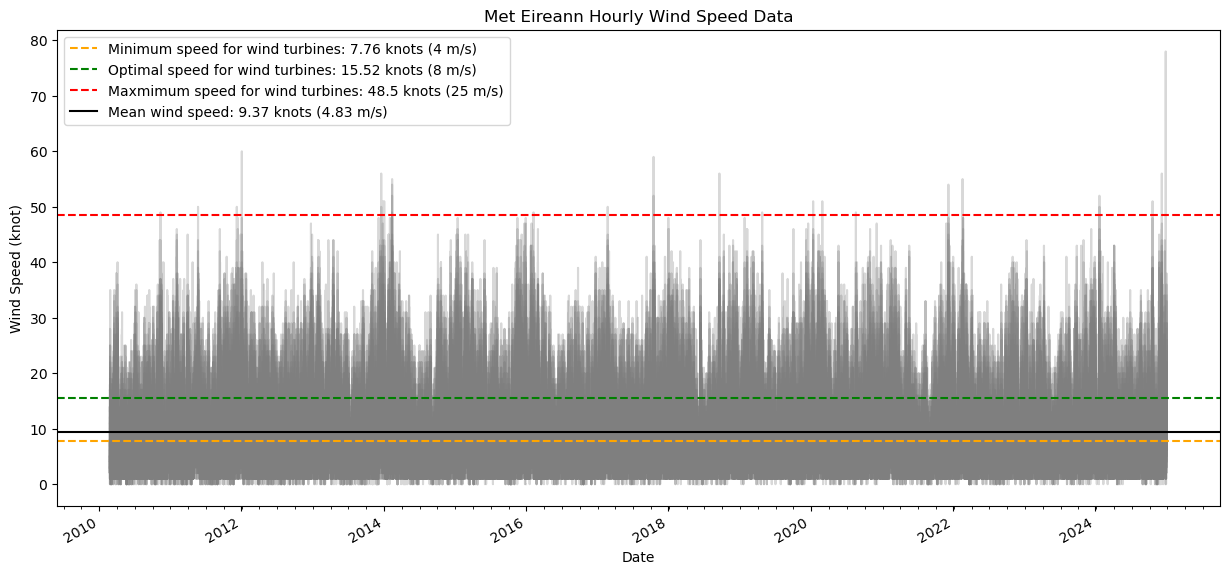

In [358]:
# Plot
fig, ax = plt.subplots(figsize=(15, 7))

# Plot dataframe.
ax.plot(hourly_df, alpha=0.3, color='tab:gray')

# Add horizontal lines for mean and optimal wind speeds for windfarms.
min_m_s = 4
optimal_m_s = 8
max_m_s = 25
conversion = 1.94
min_value = min_m_s * conversion
optimal_value = optimal_m_s * conversion
max_value = max_m_s * conversion

ax.axhline(min_value, color='orange', linestyle='--', label=f'Minimum speed for wind turbines: {min_value} knots ({min_m_s} m/s)')
ax.axhline(optimal_value, color='green', linestyle='--', label=f'Optimal speed for wind turbines: {optimal_value} knots ({optimal_m_s} m/s)')
ax.axhline(max_value, color='red', linestyle='--', label=f'Maxmimum speed for wind turbines: {max_value} knots ({max_m_s} m/s)')

# Add mean line.
mean_wdsp = hourly_df.mean().mean()
ax.axhline(mean_wdsp, color='black', linestyle='-', label=(f'Mean wind speed: {mean_wdsp:.2f} knots ({mean_wdsp/conversion:.2f} m/s)'))

locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_minor_locator(AutoMinorLocator(8))
fig.autofmt_xdate()

ax.set_ylabel("Wind Speed (knot)")
ax.set_xlabel('Date')

ax.set_title("Met Eireann Hourly Wind Speed Data")

ax.legend()

plt.show()

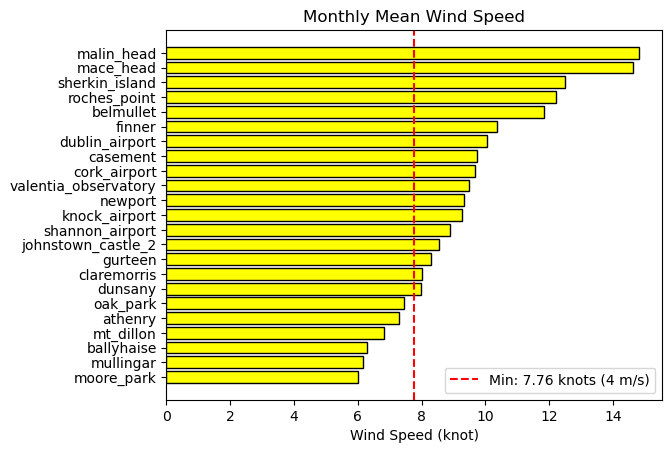

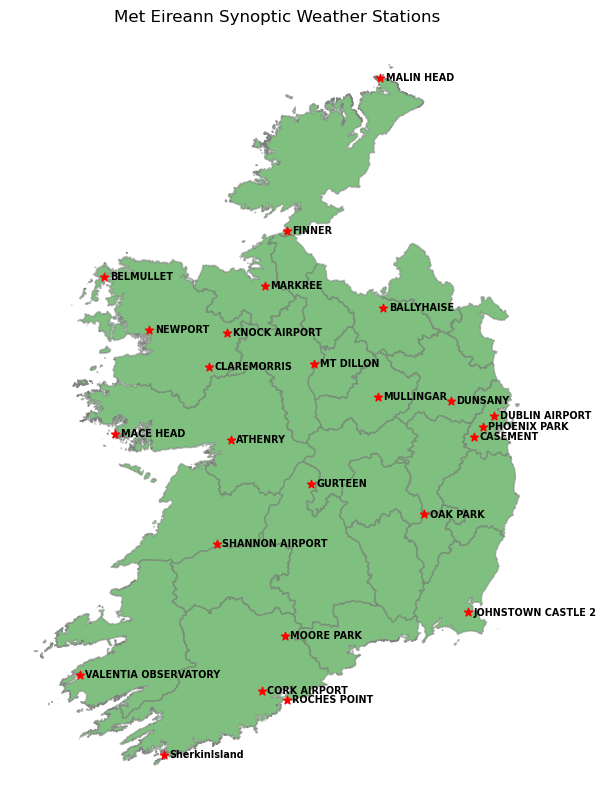

In [378]:
# Let's plot the mean hourly wind speed for each station.
fig, ax = plt.subplots()

# Get the hourly mean for each station.
x = hourly_df.mean().sort_values(ascending=True)

# Horizontal bar chart.
ax.barh(x.index, x, color='yellow', edgecolor='black')

# Add the vertical line
min_m_s = 4
optimal_m_s = 8
max_m_s = 25
conversion = 1.94
min_value = min_m_s * conversion

ax.axvline(min_value, color='red', linestyle='--', label=f'Min: {min_value} knots ({min_m_s} m/s)')

ax.set_title("Monthly Mean Wind Speed")
ax.set_xlabel("Wind Speed (knot)")
ax.legend()

ireland_map()

plt.show()

In [ ]:
# Let's calculate the % of time that the wind speed is optimal for wind turbines.
min_wdsp = 7.76
max_wdsp = 48.5

percentages = {}

for col in hourly_df:
    percentage = ((hourly_df[col] > min_wdsp) & (hourly_df[col] < max_wdsp)).mean() * 100
    percentages[col] = percentage

# https://www.datacamp.com/tutorial/sort-a-dictionary-by-value-python
sorted_pct = dict(sorted(percentages.items(), key=lambda item: item[1], reverse=True))

for col, pct in sorted_pct.items():
    print(f'{col}: {pct:.2f}%')

malin_head: 83.32%
mace_head: 81.52%
sherkin_island: 74.93%
roches_point: 74.92%
belmullet: 71.22%
dublin_airport: 65.06%
cork_airport: 61.33%
valentia_observatory: 59.89%
finner: 59.42%
casement: 59.28%
newport: 58.33%
knock_airport: 57.73%
shannon_airport: 54.89%
johnstown_castle_2: 52.89%
gurteen: 50.63%
dunsany: 48.93%
claremorris: 48.09%
oak_park: 42.80%
athenry: 42.02%
mt_dillon: 37.87%
ballyhaise: 32.22%
moore_park: 29.94%
mullingar: 29.83%


Hourly correlation: 0.08206980576499133
Monthly correlation: -0.11827531676019234


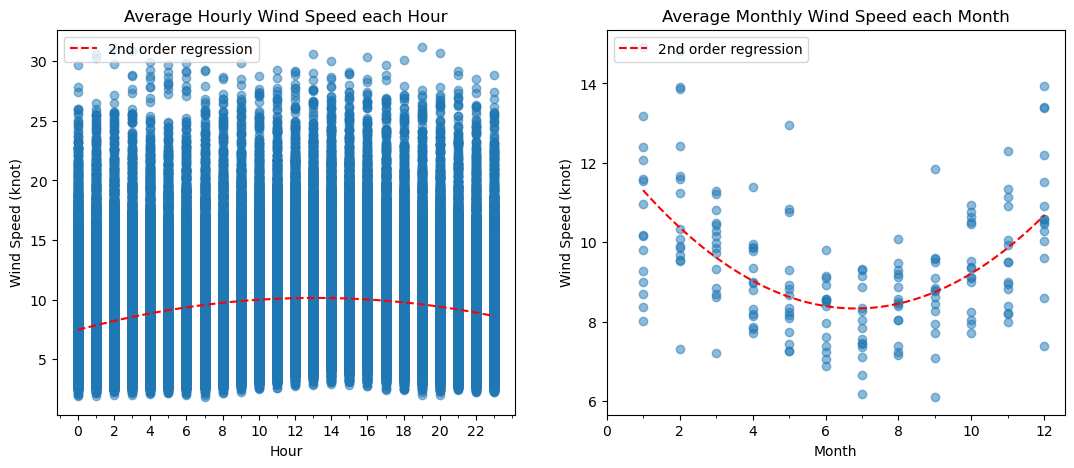

In [434]:
# Let's check if any correlation between the time of day/month and the wind speed.

####
# Create new dataframe with hour and mean wind speed.
hourly_mean = pd.DataFrame(hourly_df.mean(axis=1), columns=['wdsp'])
hourly_mean['hour'] = hourly_mean.index.hour

# Correlation between wind speed and hour.
corr_wind_hour = hourly_mean['hour'].corr(hourly_mean['wdsp'])
print(f'Hourly correlation: {corr_wind_hour}')

# Plot the hourly wind.
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(13, 5))

x_h = hourly_mean['hour']
y_h = hourly_mean['wdsp']

ax1.scatter(x_h, y_h, color='tab:blue', alpha=0.5)

# Fit a 2nd order polynomial to the data
# https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html
coefficients = np.polyfit(x_h, y_h, 2)
polynomial = np.poly1d(coefficients)

# Generate x values for the regression line.
x_h_reg = np.linspace(min(x_h), max(x_h))
y_h_reg = polynomial(x_h_reg)

# Plot the regression line.
ax1.plot(x_h_reg, y_h_reg, 'r--', label='2nd order regression')

xticks = np.arange(0, 24, 2)
ax1.set_xticks(xticks)
ax1.xaxis.set_minor_locator(AutoMinorLocator(2))
ax1.set_xlabel('Hour')
ax1.set_ylabel('Wind Speed (knot)')
ax1.set_title('Average Hourly Wind Speed each Hour')

ax1.legend(loc=2)

####
# Create new dataframe with month and mean wind speed.
monthly_df = hourly_df.resample("ME").mean()

monthly_mean = pd.DataFrame(monthly_df.mean(axis=1), columns=['wdsp'])
monthly_mean['month'] = monthly_df.index.month

# Correlation between wind speed and month.
corr_wind_month = monthly_mean['month'].corr(monthly_mean['wdsp'])
print(f'Monthly correlation: {corr_wind_month}')

# Plot the monthly wind.
x_m = monthly_mean['month']
y_m = monthly_mean['wdsp']

ax2.scatter(x_m, y_m, color='tab:blue', alpha=0.5)

# Fit a 2nd order polynomial to the data
# https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html
coefficients = np.polyfit(x_m, y_m, 2)
polynomial = np.poly1d(coefficients)

# Generate x values for the regression line.
x_m_reg = np.linspace(min(x_m), max(x_m))
y_m_reg = polynomial(x_m_reg)

# Plot the regression line.
ax2.plot(x_m_reg, y_m_reg, 'r--', label='2nd order regression')

xticks = np.arange(0, 13, 2)
ax2.set_xticks(xticks)
ax2.xaxis.set_minor_locator(AutoMinorLocator(2))
ax2.set_xlabel('Month')
ax2.set_ylabel('Wind Speed (knot)')
ax2.set_title('Average Monthly Wind Speed each Month')

ax2.legend(loc=2)

# Show plot.
plt.show()

Correlation: -0.12605193644454837


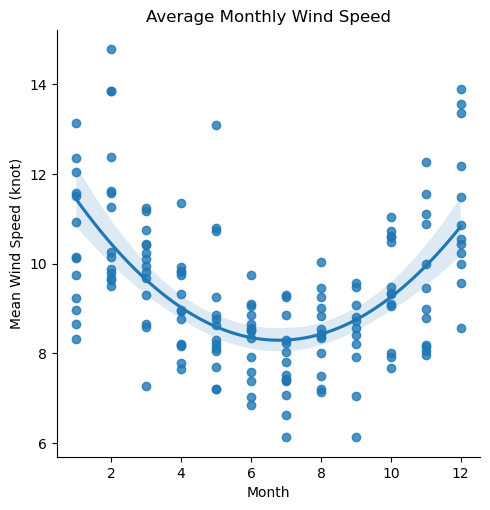

In [315]:
# Let's check if any correlation between the month the windspeed.

# Create new dataframe with month and mean wind speed.
monthly_mean = pd.DataFrame(monthly_df.mean(axis=1), columns=['wdsp'])
monthly_mean['month'] = monthly_mean.index.month

# Correlation between wind speed and month.
corr_windspeed = monthly_mean["month"].corr(monthly_mean["wdsp"])
print(f'Correlation: {corr_windspeed}')

# Plot the monthly wind speed and add a regression line.
title = "Average Monthly Wind Speed"
xlabel = "Month"
ylabel = "Mean Wind Speed (knot)"

sns.lmplot(data=monthly_mean, x='month', y='wdsp', order=2).set(title=title, xlabel=xlabel, ylabel=ylabel)

plt.show()

In [316]:
# Let's look at data on electricity generation from wind.
# https://www.seai.ie/data-and-insights/seai-statistics/monthly-energy-data/electricity-monthly#comp000064913259000000056f1221
seai_csv = "./data/seai_wind_gen_data.csv"
seai_df = pd.read_csv(seai_csv)
seai_df.head()

,Month of Period,Generation Source,Unit,Year of Period,Aggregation,Emission / Energy,Generated
0,January 2010,Wind,GWh,2010,Indig. Product.,Energy,248.002
1,February 2010,Wind,GWh,2010,Indig. Product.,Energy,150.952
2,March 2010,Wind,GWh,2010,Indig. Product.,Energy,251.394
3,April 2010,Wind,GWh,2010,Indig. Product.,Energy,186.269
4,May 2010,Wind,GWh,2010,Indig. Product.,Energy,168.528


In [317]:
# Let's clean the data.

# Add datetime column
seai_df['date'] = pd.to_datetime(seai_df['Month of Period'], format="%B %Y")


In [318]:
# Set datetime as index.
seai_df = seai_df.set_index('date')

In [319]:
# Add month column.
seai_df['month'] = seai_df.index.month

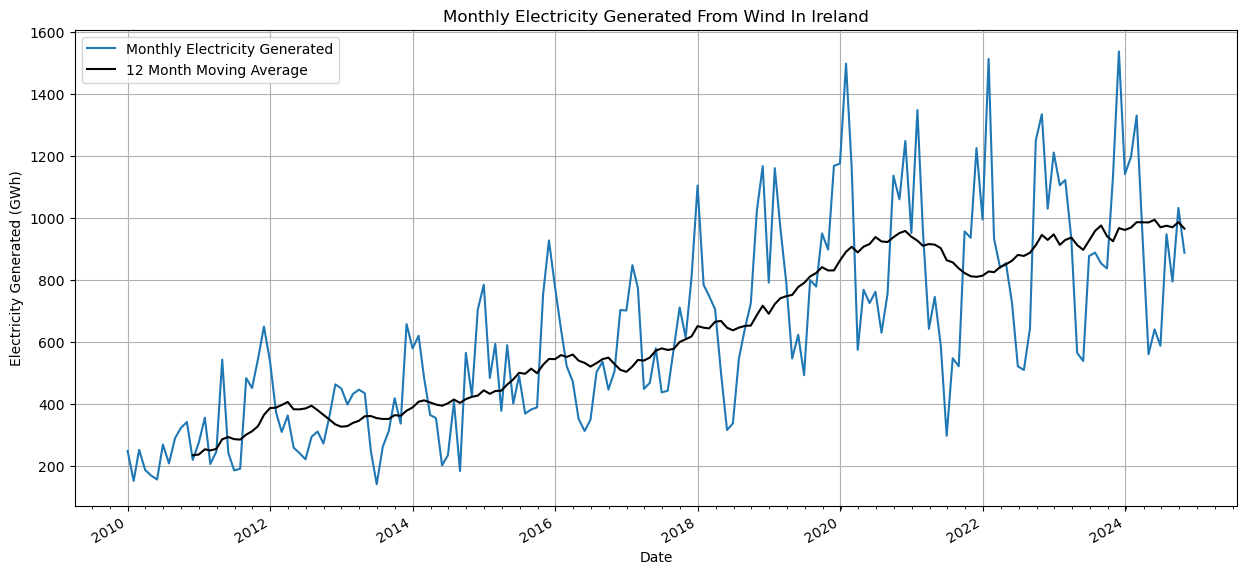

In [320]:
# Plot.
fig, ax = plt.subplots(figsize=(15, 7))

# Plot dataframe.
ax.plot(seai_df['Generated'], color='tab:blue', label='Monthly Electricity Generated')

# Add 12 month moving aveage to plot.
x = seai_df['Generated'].rolling(window=12).mean()

ax.plot(x, color='black', label='12 Month Moving Average')

locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_minor_locator(AutoMinorLocator(8))
fig.autofmt_xdate()

ax.set_ylabel("Electricity Generated (GWh)")
ax.set_xlabel('Date')

ax.grid(True)

ax.set_title("Monthly Electricity Generated From Wind In Ireland")

ax.legend()

plt.show()

Correlation: -0.0017869110205504535


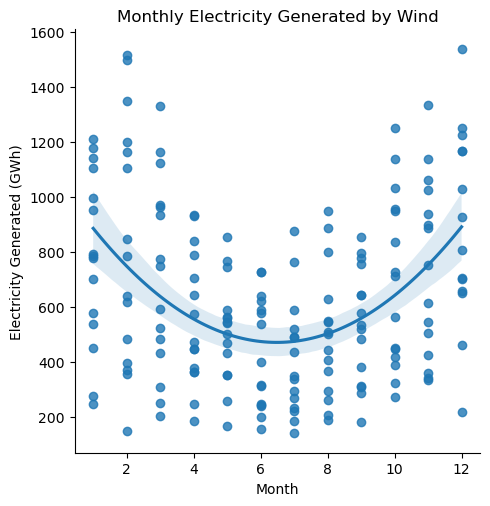

In [321]:
# Let's check if any correlation between the month and the electricity generated.

# Correlation between electricity generated and month.
corr_elec_gen = seai_df['month'].corr(seai_df['Generated'])
print(f'Correlation: {corr_elec_gen}')

# Plot the monthly wind speed and add a regression line.
title = "Monthly Electricity Generated by Wind"
xlabel = "Month"
ylabel = "Electricity Generated (GWh)"

sns.lmplot(data=seai_df, x='month', y='Generated', order=2).set(title=title, xlabel=xlabel, ylabel=ylabel)

plt.show()

In [322]:
# More wind gen data from eirgrid.
# https://www.eirgrid.ie/grid/system-and-renewable-data-reports
eirgrid_csv = './data/eirgrid_wind_gen_data.csv'

eirgrid_df = pd.read_csv(eirgrid_csv)
eirgrid_df.head()

,DateTime,IE Generation,IE Demand,IE Wind Availability,IE Wind Generation
0,01/01/2014 00:00,2752.48,2898.72,1053.11,1020.23
1,01/01/2014 00:15,2733.59,2868.97,1021.59,995.07
2,01/01/2014 00:30,2686.17,2826.42,972.06,932.71
3,01/01/2014 00:45,2657.56,2786.94,985.81,959.06
4,01/01/2014 01:00,2584.65,2723.94,958.63,920.82


In [323]:
# Let's clean the data.

# Add datetime column
eirgrid_df['date'] = pd.to_datetime(eirgrid_df['DateTime'], format="%d/%m/%Y %H:%M")

In [324]:
# Set datetime as index.
eirgrid_df = eirgrid_df.set_index('date')

In [325]:
# Let's drop the DateTime column.
eirgrid_df = eirgrid_df.drop(columns='DateTime')

In [326]:
# Let's add a month and an hour column.
eirgrid_df['month'] = eirgrid_df.index.month
eirgrid_df['hour'] = eirgrid_df.index.hour

In [327]:
eirgrid_df.head()

,IE Generation,IE Demand,IE Wind Availability,IE Wind Generation,month,hour
date,,,,,,
2014-01-01 00:00:00,2752.48,2898.72,1053.11,1020.23,1,0
2014-01-01 00:15:00,2733.59,2868.97,1021.59,995.07,1,0
2014-01-01 00:30:00,2686.17,2826.42,972.06,932.71,1,0
2014-01-01 00:45:00,2657.56,2786.94,985.81,959.06,1,0
2014-01-01 01:00:00,2584.65,2723.94,958.63,920.82,1,1


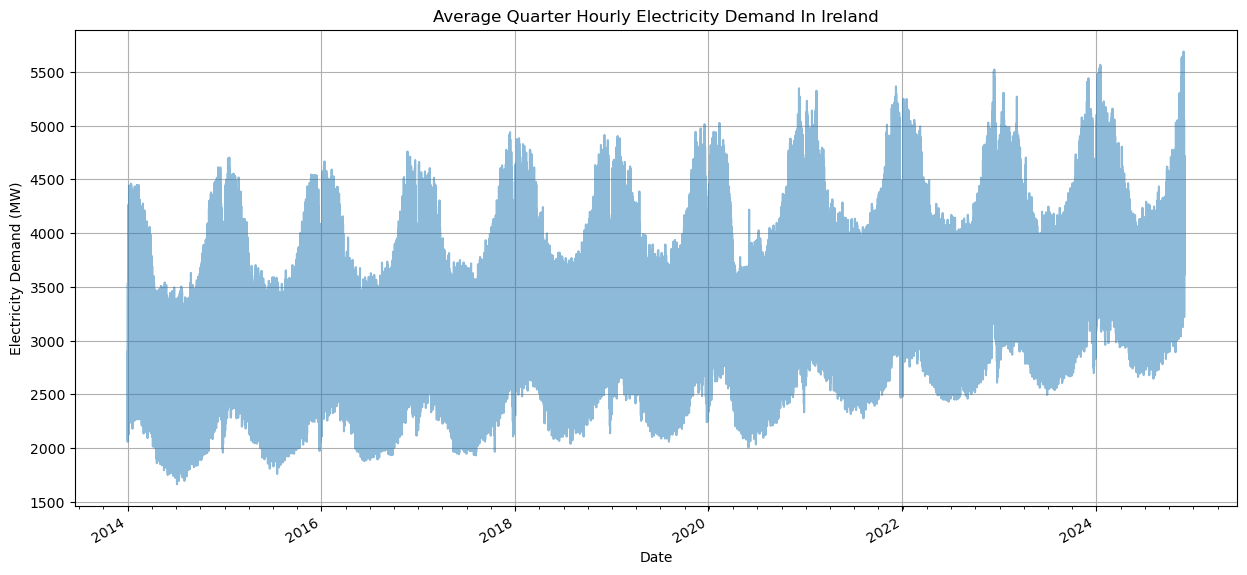

In [328]:
# Plot.
fig, ax = plt.subplots(figsize=(15, 7))

# Plot dataframe.
ax.plot(eirgrid_df['IE Demand'], color='tab:blue', alpha=0.5)

locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_minor_locator(AutoMinorLocator(8))
fig.autofmt_xdate()

ax.set_ylabel("Electricity Demand (MW)")
ax.set_xlabel('Date')

ax.grid(True)

ax.set_title("Average Quarter Hourly Electricity Demand In Ireland")

plt.show()

Correlation: -0.049229804544632126


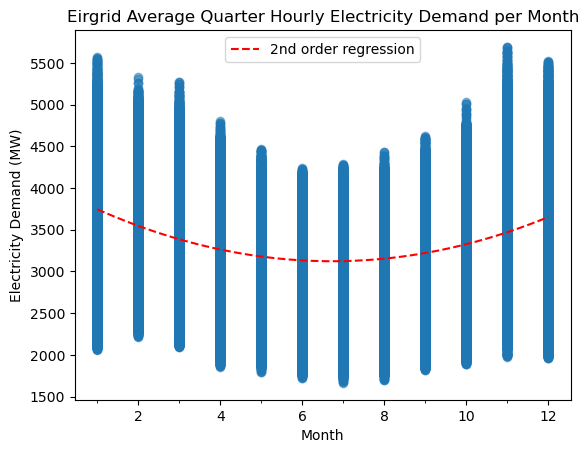

In [329]:
# Let's check if any correlation between the month and the electricity demand.

# Correlation between electricity demand and month.
corr_elec_month = eirgrid_df['month'].corr(eirgrid_df['IE Demand'])
print(f'Correlation: {corr_elec_month}')

# Plot the electricity demand.
fig, ax = plt.subplots()

x = eirgrid_df['month']
y = eirgrid_df['IE Demand']

ax.scatter(x, y, color='tab:blue', alpha=0.5)

# Fit a 2nd order polynomial to the data
# https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html
coefficients = np.polyfit(x, y, 2)
polynomial = np.poly1d(coefficients)

# Generate x values for the regression line.
x_reg = np.linspace(min(x), max(x))
y_reg = polynomial(x_reg)

# Plot the regression line.
ax.plot(x_reg, y_reg, 'r--', label='2nd order regression')

ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.set_xlabel('Month')
ax.set_ylabel('Electricity Demand (MW)')
ax.set_title('Eirgrid Average Quarter Hourly Electricity Demand per Month')

ax.legend(loc=9)
# Show plot.
plt.show()

Correlation: 0.5165410896594776


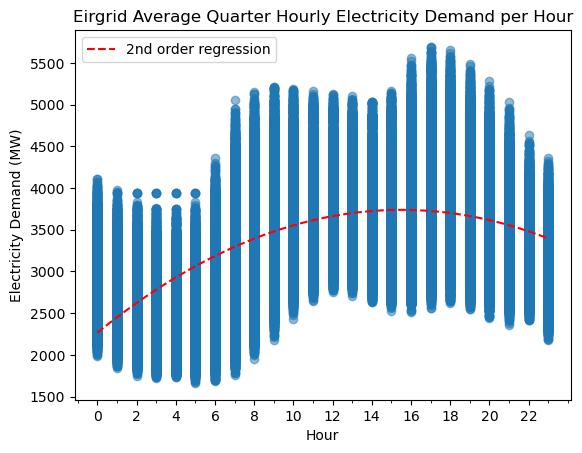

In [330]:
# Let's check if any correlation between the hour and the electricity demand.

# Correlation between electricity demand and hour.
corr_elec_hour = eirgrid_df['hour'].corr(eirgrid_df['IE Demand'])
print(f'Correlation: {corr_elec_hour}')

# Plot the electricity demand.
fig, ax = plt.subplots()

x = eirgrid_df['hour']
y = eirgrid_df['IE Demand']

ax.scatter(x, y, color='tab:blue', alpha=0.5)

# Fit a 2nd order polynomial to the data
# https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html
coefficients = np.polyfit(x, y, 2)
polynomial = np.poly1d(coefficients)

# Generate x values for the regression line.
x_reg = np.linspace(min(x), max(x))
y_reg = polynomial(x_reg)

# Plot the regression line.
ax.plot(x_reg, y_reg, 'r--', label='2nd order regression')

xticks = np.arange(0, 24, 2)
ax.set_xticks(xticks)
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.set_xlabel('Hour')
ax.set_ylabel('Electricity Demand (MW)')
ax.set_title('Eirgrid Average Quarter Hourly Electricity Demand per Hour')

ax.legend(loc=2)
# Show plot.
plt.show()

In [331]:
# Function to import and clean the monthly weather date.
def import_hourly_data():

    # File containing csv URLs.
    txt_file = "./data/download-file-list-hourly.txt"

    # Regex pattern to find the start of useful data in CSV files.
    regex = r"^date(?!:)"

    # Columns to import to dataframe.
    columns = ["date", "wdsp"]

    # Numeric columns.
    numeric_columns = ["wdsp"]

    # Index column.
    index = 'date'

    # List to store the dataframes.
    dataframes = []

    # Regex pattern to find the column header row in CSV files.
    regex_pattern = re.compile(regex, re.IGNORECASE)

    # Read the URLs from the txt file and strip newlines.
    with open(txt_file) as f:
        csv_urls = [line.strip() for line in f if line.strip()]

    # Loop through the URLs.
    for url in csv_urls:
        try:
            # Send GET request to the URL.
            response = requests.get(url)
            if response.status_code != 200:
                print(f"Failed to retrieve the CSV file. Status code: {response.status_code}")
                continue

            # Treat response content as file-like object.
            csv_content = response.text
            csv_file = StringIO(csv_content)

            # Find the row with column headers.
            csv_reader = csv.reader(csv_file)

            station_name = ",".join(next(csv_reader)).split("Station Name: ")[1].lower().replace(" ", "_")

            for row_number, row in enumerate(csv_reader):
                row_string = ",".join(row)
                if regex_pattern.search(row_string):
                    break
            else:
                print(f"Error finding regex pattern: \"{regex_pattern.pattern}\" in {url}")
                continue

            # Reset the file pointer and import the data to DataFrame.
            csv_file.seek(0)
            df = pd.read_csv(csv_file, skiprows=row_number, index_col=index, usecols=columns, low_memory=False)

            # Convert index to datetime.
            df.index = pd.to_datetime(df.index, format="%d-%b-%Y %H:%M")
            
            # Convert data to numeric.
            for col in numeric_columns:
                df[col] = pd.to_numeric(df[col], errors="coerce")

            # Replace any blanks with NAs.
            df = df.replace(" ", np.nan)

            # Update column names to include station name.
            df.columns = [f"{station_name}"]

            # Append dataframes to list.
            dataframes.append(df)

            print(f"Imported {url} as {station_name}")

        except Exception as e:
            print(f"An error occurred while processing {url} ({station_name}): {e}")

    return dataframes


# Call the function.
hourly_dataframes = import_hourly_data()

Imported https://cli.fusio.net/cli/climate_data/webdata/hly1875.csv as athenry
Imported https://cli.fusio.net/cli/climate_data/webdata/hly675.csv as ballyhaise
Imported https://cli.fusio.net/cli/climate_data/webdata/hly2375.csv as belmullet
Imported https://cli.fusio.net/cli/climate_data/webdata/hly3723.csv as casement
Imported https://cli.fusio.net/cli/climate_data/webdata/hly2175.csv as claremorris
Imported https://cli.fusio.net/cli/climate_data/webdata/hly3904.csv as cork_airport
Imported https://cli.fusio.net/cli/climate_data/webdata/hly532.csv as dublin_airport
Imported https://cli.fusio.net/cli/climate_data/webdata/hly1375.csv as dunsany
Imported https://cli.fusio.net/cli/climate_data/webdata/hly2075.csv as finner
Imported https://cli.fusio.net/cli/climate_data/webdata/hly1475.csv as gurteen
Imported https://cli.fusio.net/cli/climate_data/webdata/hly1775.csv as johnstown_castle_2
Imported https://cli.fusio.net/cli/climate_data/webdata/hly4935.csv as knock_airport
Imported https:/

In [332]:
# Combine into one dataframe and normalize based on the date index.
hourly_df = pd.concat(hourly_dataframes, axis=1, join='inner')

# Let's take a look.
hourly_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 129537 entries, 2010-02-25 01:00:00 to 2025-01-01 00:00:00
Data columns (total 23 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   athenry               129488 non-null  float64
 1   ballyhaise            129509 non-null  float64
 2   belmullet             129536 non-null  float64
 3   casement              129533 non-null  float64
 4   claremorris           129330 non-null  float64
 5   cork_airport          129537 non-null  int64  
 6   dublin_airport        129537 non-null  int64  
 7   dunsany               129524 non-null  float64
 8   finner                122116 non-null  float64
 9   gurteen               129502 non-null  float64
 10  johnstown_castle_2    129503 non-null  float64
 11  knock_airport         129537 non-null  float64
 12  mace_head             129445 non-null  float64
 13  malin_head            129485 non-null  float64
 14  moore_park        

Correlation: 0.08206980576499133


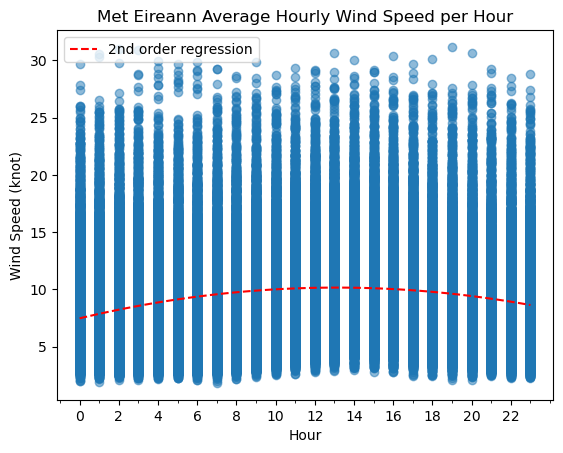

In [333]:
# Let's check if any correlation between the hour and the electricity demand.

# Create new dataframe with hour and mean wind speed.
hourly_mean = pd.DataFrame(hourly_df.mean(axis=1), columns=['wdsp'])
hourly_mean['hour'] = hourly_mean.index.hour

# Correlation between electricity demand and hour.
corr_wind_hour = hourly_mean['hour'].corr(hourly_mean['wdsp'])
print(f'Correlation: {corr_wind_hour}')

# Plot the electricity demand.
fig, ax = plt.subplots()

x = hourly_mean['hour']
y = hourly_mean['wdsp']

ax.scatter(x, y, color='tab:blue', alpha=0.5)

# Fit a 2nd order polynomial to the data
# https://numpy.org/doc/stable/reference/generated/numpy.polyfit.html
coefficients = np.polyfit(x, y, 2)
polynomial = np.poly1d(coefficients)

# Generate x values for the regression line.
x_reg = np.linspace(min(x), max(x))
y_reg = polynomial(x_reg)

# Plot the regression line.
ax.plot(x_reg, y_reg, 'r--', label='2nd order regression')

xticks = np.arange(0, 24, 2)
ax.set_xticks(xticks)
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
ax.set_xlabel('Hour')
ax.set_ylabel('Wind Speed (knot)')
ax.set_title('Met Eireann Average Hourly Wind Speed per Hour')

ax.legend(loc=2)
# Show plot.
plt.show()

In [334]:
# Import installed windfarm capacity ireland.
# https://cms.eirgrid.ie/sites/default/files/publications/System-and-Renewable-Data-Summary-Report-December-2024.xlsx
csv_file = './data/eirgrid_installed_wind_capacity.csv'

wind_capacity = pd.read_csv(csv_file, usecols=['Year', 'Total'], index_col='Year')

In [335]:
# Convert index to datetime.
wind_capacity.index = pd.to_datetime(wind_capacity.index, format="%Y")

In [336]:
# Convert Total values to numeric.
wind_capacity["Total"] = pd.to_numeric(wind_capacity["Total"], errors="coerce")

In [337]:
wind_capacity.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 34 entries, 1990-01-01 to 2023-01-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   Total   34 non-null     float64
dtypes: float64(1)
memory usage: 544.0 bytes


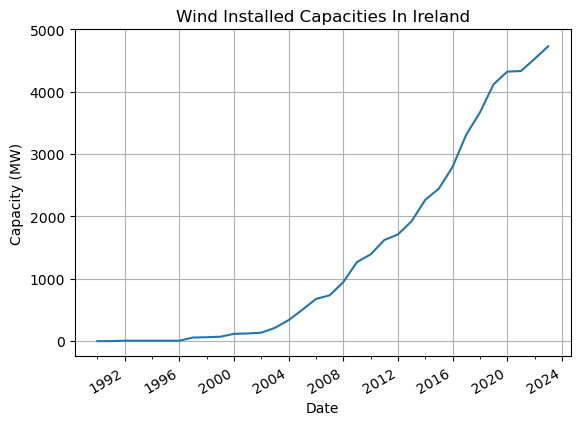

In [338]:
fig, ax = plt.subplots()

ax.plot(wind_capacity)

locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_formatter(formatter)
ax.xaxis.set_minor_locator(AutoMinorLocator(2))
fig.autofmt_xdate()

ax.set_ylabel("Capacity (MW)")
ax.set_xlabel('Date')

yticks = np.arange(0, 6000, 1000)
ax.set_yticks(yticks)

ax.grid(True)

ax.set_title("Wind Installed Capacities In Ireland")

plt.show()

In [339]:
# Dataframe to use to predict 2025 wind speed.
monthly_wind = pd.DataFrame(monthly_df.mean(axis=1), columns=['wdsp'])

monthly_wind['month'] = monthly_wind.index.month

monthly_wind.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 158 entries, 2011-02-01 to 2024-11-01
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   wdsp    158 non-null    float64
 1   month   158 non-null    int32  
dtypes: float64(1), int32(1)
memory usage: 3.1 KB


[10.51822742 11.29901186  9.82826087  9.04562394  8.92049689  8.29337945
  7.80755223  8.47195196  8.36007905  9.48434175  9.6141469  11.22192029]
0.43754443415281075


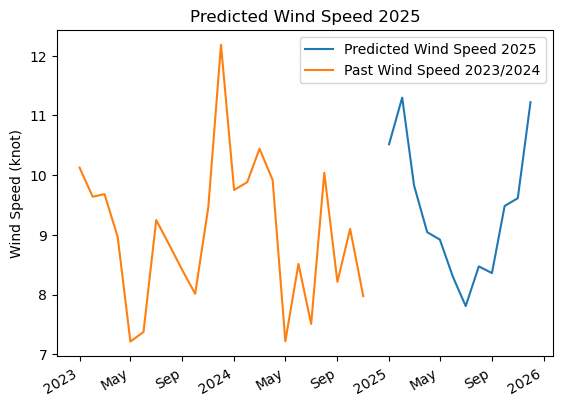

In [340]:
# Variables
x = monthly_wind[['month']]
y = monthly_wind['wdsp']

# Decicion Tree
model = tree.DecisionTreeRegressor()
model = model.fit(x, y)

months_2025 = pd.DataFrame({'month': np.arange(1, 13)})
wdsp_2025 = model.predict(months_2025)

print(wdsp_2025)
print(model.score(x, y))

fut_wind = pd.DataFrame({
    'wdsp': wdsp_2025,
    'month': np.arange(1, 13),
    'date': pd.date_range(start='2025-01-01', end='2025-12-01', freq='MS')})

past_wind = monthly_wind[monthly_wind.index > '2022-12-31']

fig, ax = plt.subplots()

ax.plot(fut_wind['date'], fut_wind['wdsp'], label="Predicted Wind Speed 2025")

ax.plot(past_wind['wdsp'], label="Past Wind Speed 2023/2024")

locator = mdates.AutoDateLocator()
formatter = mdates.ConciseDateFormatter(locator)
ax.xaxis.set_major_formatter(formatter)
#ax.xaxis.set_minor_locator(AutoMinorLocator())
fig.autofmt_xdate()

ax.set_ylabel('Wind Speed (knot)')
ax.set_title('Predicted Wind Speed 2025')
ax.legend()

plt.show()